In [42]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
import math
from __future__ import division
sns.set_style('whitegrid')

In [43]:
# Import NCDC dataset
ipath= "../6581206807038dat.txt"
# ipath= "../marham.txt"
uipath = unicode(ipath , "utf8")
file2 = open(uipath)
df = pd.read_csv(uipath,header=0, skipinitialspace=True)
df.drop(['USAF', 'NCDC', 'I','QCP','Q','Q.1','I.1','Unnamed: 12'], 1,inplace=True)
df.rename(columns={'Date':'date','Dir': 'dir', 'Spd':'speed'}, inplace=True)
df.describe()

,date,HrMn,dir,speed
count,853335.000000,853335.000000,853335.000000,853335.000000
mean,19922155.097373,1163.599446,296.597628,3.815579
std,128228.968011,691.447205,323.742323,18.270134
min,19650801.000000,0.000000,9.000000,0.000000
25%,19820629.000000,600.000000,80.000000,1.500000
50%,19900223.000000,1200.000000,190.000000,3.100000
75%,20041118.000000,1750.000000,290.000000,5.100000
max,20150801.000000,2358.000000,999.000000,999.900000


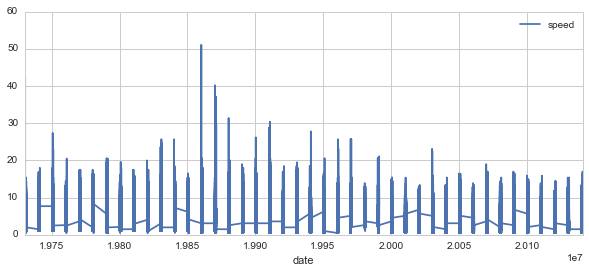

In [44]:
# Select year 1945-2014, dir < 999, speed<999
df = df[(df['dir'] < 999) & (df['speed'] < 999)& (df['date'] > 19720000) &(df['date'] < 20150000)]
df.rename(columns={'speed':'speed_mps'}, inplace=True)
df['speed']=df['speed_mps']
df.index= df['date']
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

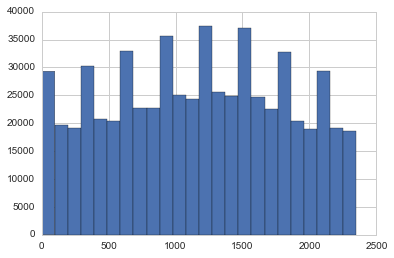

In [45]:
# Check time sample distribution,
# and found that its not equally sampled.
time = df[df['HrMn'] % 10 <= 0.1]
time['HrMn'].hist(bins = 24)

In [46]:
df=df[df['Type']=='FM-15']
# df=df[df['Type']=='FM-12']

In [47]:
df['artifact'] = False

# Simple artifact detection
# 1. dir error
df.ix[df['dir'] % 10 >=0.1,'artifact']=True
artifact = df[df['dir'] % 10 >=0.1]
print len(artifact)

32


In [48]:
# 2. Speed remain error
# Generate the first digit of fractional part of the speed(after convert to knot unit)
# e.g. 48.5 -> 5
# import math
# df['speed']=df['speed_mps']*1.943845
# df['speed_remain'] = df['speed'].apply(lambda x: math.modf(x*10 % 10)[1])

# # Plot the distribution of speed_remain,
# # and compare between year<2000 and > 2000
# temp = df[(df['date'] > 20000000)]
# temp['speed_remain'].hist(bins = 10,alpha=0.5)
# print temp['speed_remain'].value_counts()

# temp = df[(df['date'] < 20000000)]
# temp['speed_remain'].hist(bins = 10,alpha=0.5)
# print temp['speed_remain'].value_counts()

In [49]:
# # From the distribution above, 
# # we can know that the legit number are only 0 and 9, all others are too rare to be normal.
# df.ix[(df['speed_remain'] >= 2)&(df['speed_remain'] <= 7),'artifact']=True
# df.drop(['speed_remain'], 1,inplace=True)
# # and then converted the speed into integer
# df.rename(columns={'speed':'speed_flt'}, inplace=True)
# df['speed'] =  df['speed_flt'].apply(lambda x: int(round(x)))
# df[df['artifact']== True].head(20)

In [50]:
df['speed'] =  df['speed_mps'].apply(lambda x: int(round(x*1.943845)))

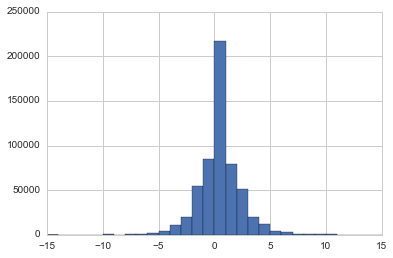

In [51]:
# pd.set_option('display.max_rows', 100)

df['incre'] = df.speed.diff(1)
df['incre'] = df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'] = df['incre_reverse'].fillna(0)
bins=np.arange(-15, 15 + 1, 1)
df['incre'].hist(bins=bins)
# df.sort('speed',ascending=False).head(30)
# print df['incre'].value_counts()

In [52]:
# df[(df['date'] >= 19790110)].head(60)
# df[(df['date'] >= 19741029)].head(60)

In [53]:
# 3. Artifact detection: sudden increase
# detect udden increase from nearby data, consider singular increase
artifact = df[((df['incre'] >= 7)&(df['incre_reverse'] >= 7))]
df.ix[((df['incre'] >= 7)&(df['incre_reverse'] >= 7)),'artifact']=True
print len(artifact)
artifact

544


,date,HrMn,Type,dir,speed_mps,speed,artifact,incre,incre_reverse
date,,,,,,,,,
19730217,19730217,550,FM-15,240,5.1,10,False,7,7
19730225,19730225,1420,FM-15,20,11.8,23,False,12,7
19730411,19730411,820,FM-15,300,9.2,18,False,12,10
19730421,19730421,120,FM-15,260,9.2,18,False,10,15
19730718,19730718,750,FM-15,240,13.8,27,False,19,21
19730726,19730726,1450,FM-15,310,7.2,14,False,8,7
19730815,19730815,1750,FM-15,20,6.1,12,False,10,7
19730829,19730829,1350,FM-15,350,8.7,17,False,10,14
19730830,19730830,1250,FM-15,240,8.2,16,False,11,10


In [54]:
artifact = df[((df['incre'] <= -7)&(df['incre_reverse'] <= -7))]
df.ix[((df['incre'] <= -7)&(df['incre_reverse'] <= -7)),'artifact']=True
print len(artifact)
artifact

366


,date,HrMn,Type,dir,speed_mps,speed,artifact,incre,incre_reverse
date,,,,,,,,,
19730310,19730310,1120,FM-15,120,3.6,7,False,-9,-11
19730311,19730311,1120,FM-15,30,3.6,7,False,-11,-10
19730403,19730403,1550,FM-15,260,2.5,5,False,-8,-13
19730409,19730409,50,FM-15,160,1.5,3,False,-16,-10
19730411,19730411,750,FM-15,280,3.0,6,False,-11,-12
19730503,19730503,920,FM-15,150,3.0,6,False,-7,-7
19730503,19730503,1320,FM-15,180,3.0,6,False,-9,-8
19730506,19730506,920,FM-15,180,1.5,3,False,-8,-10
19730609,19730609,150,FM-15,260,3.0,6,False,-7,-10


In [55]:
### Summary of artifacts, which belongs to FM-15
# 3 types are handled:
# 1. Sudden increase in speed, e.g. 5, 50, 5. the 50 is detected
# 2. Strange wind direction record, e.g. 61, 78, 127, since wind dir are setcored into 10 degree
# 3. Speed not near an integer after converting back to knot, e.g. 23.4, 7.75

artifact = df[(df['artifact']==True)]
print len(artifact)
artifact

940


,date,HrMn,Type,dir,speed_mps,speed,artifact,incre,incre_reverse
date,,,,,,,,,
19730217,19730217,550,FM-15,240,5.1,10,True,7,7
19730225,19730225,1420,FM-15,20,11.8,23,True,12,7
19730310,19730310,1120,FM-15,120,3.6,7,True,-9,-11
19730311,19730311,1120,FM-15,30,3.6,7,True,-11,-10
19730403,19730403,1550,FM-15,260,2.5,5,True,-8,-13
19730409,19730409,50,FM-15,160,1.5,3,True,-16,-10
19730411,19730411,750,FM-15,280,3.0,6,True,-11,-12
19730411,19730411,820,FM-15,300,9.2,18,True,12,10
19730421,19730421,120,FM-15,260,9.2,18,True,10,15


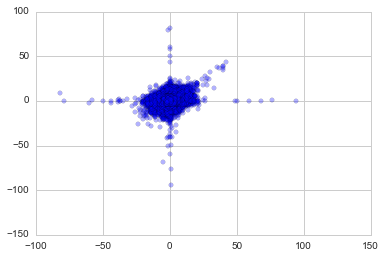

In [56]:
import pylab
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
# new_set = [df['incre'],df['incre_reverse']]
X = df['incre']
Y = df['incre_reverse']

plt.scatter(X, Y, alpha = 0.3)
# plt.contour(X, Y, alpha=.75, cmap='jet')

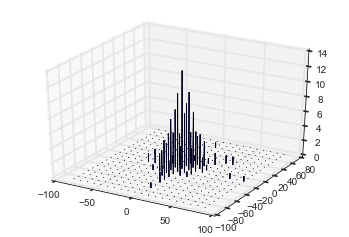

In [71]:
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# x, y = np.random.rand(2, 100) * 4
x = df['incre']
y = df['incre_reverse']
hist, xedges, yedges = np.histogram2d(x, y, bins=20)

elements = (len(xedges) - 1) * (len(yedges) - 1)
xpos, ypos = np.meshgrid(xedges[:-1]+0.25, yedges[:-1]+0.25)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(elements)
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
# dz is the count
dz = np.log(hist.flatten())

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x10ed71f80>

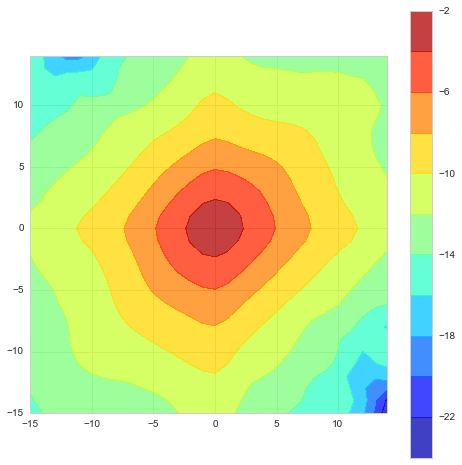

In [73]:
sample = np.array(zip(df['incre'], df['incre_reverse']))

# Empirical Distribution
from sklearn.neighbors import KernelDensity
from itertools import product
from math import *
kde = KernelDensity().fit(sample)

X = np.arange(-15, 15, 1)
Y = X
N, M = len(X), len(Y)
Z = np.zeros((N, M))
for i, (x,y) in enumerate(product(X,Y)):
    Z[np.unravel_index(i, (N,M))] = kde.score([x,y])

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
plt.contourf(X, Y, Z.T, 10, alpha=.75, cmap='jet')
plt.colorbar()

In [62]:
# sample = np.array(zip(df['incre'], df['incre_reverse']))

# # Empirical Distribution
# from sklearn.neighbors import KernelDensity
# from itertools import product
# from math import *

# X = np.arange(-15, 15, 1)
# Y = np.arange(-15, 15, 1)
# N, M = len(X), len(Y)
# Z = np.zeros((N, M))
# for i, (x,y) in enumerate(product(X,Y)):
#     Z[np.unravel_index(i, (N,M))] = # count of the number of (x,y)

# fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
# ax.set_aspect('equal')
# plt.contourf(X, Y, Z.T, 10, alpha=.75, cmap='jet')
# plt.colorbar()
# range(-20,20)

[-20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19]